In [18]:
import os
import math
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa


from torch.utils.data import Dataset, DataLoader, random_split
import torch
from models import Encoder, Decoder, BiLSTMSeq2Seq
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def preprocess_music(file_path, n_mfcc=50):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc)
    return mfcc.T


def process_file(file):
    return preprocess_music(os.path.join(base_path, file))


base_path = "music_files"
file_list = [file for file in os.listdir(base_path) if file.endswith(".mp3")]

num_workers = min(cpu_count(), len(file_list))


with Pool(num_workers) as pool:
    mfccs = list(tqdm(pool.imap(process_file, file_list), total=len(file_list)))


  0%|          | 0/285 [00:00<?, ?it/s]

In [7]:
def pad_and_truncate_sequences(sequences, maxlen, padding_value=0.0):
    """
    Pads and truncates sequences to the specified maximum length.

    Args:
        sequences (list of tensors): List of variable-length sequences (each is a 1D tensor).
        maxlen (int): Maximum length to pad or truncate to.
        padding_value (float): Value used for padding (default is 0.0).

    Returns:
        Tensor: Padded and truncated tensor with shape (batch_size, maxlen, feature_dim).
    """
    # Convert list of sequences to a batch tensor using pad_sequence
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=padding_value)

    # Truncate sequences if they exceed maxlen
    if padded_sequences.size(1) > maxlen:
        padded_sequences = padded_sequences[:, :maxlen, :]
    # Pad sequences to maxlen if they are shorter
    elif padded_sequences.size(1) < maxlen:
        # Create a tensor of shape (batch_size, maxlen, feature_dim) filled with padding_value
        pad_shape = (padded_sequences.size(0), maxlen - padded_sequences.size(1), padded_sequences.size(2))
        padding = torch.full(pad_shape, padding_value)
        padded_sequences = torch.cat([padded_sequences, padding], dim=1)

    return padded_sequences

In [10]:
mfccs_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in mfccs]
mfccs_padded = pad_and_truncate_sequences(mfccs_tensors, maxlen=5000)

In [12]:
mfccs_padded.shape

torch.Size([285, 5000, 50])

In [16]:
model = BiLSTMSeq2Seq(input_dim=50, hidden_dim_1=64, hidden_dim_2=256).to(device)

In [19]:
class MFCCDataset(Dataset):
    def __init__(self, data):
        """
        Custom Dataset for MFCC data.

        Args:
            data (Tensor): The input data tensor of shape (num_samples, ...).
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_stream = self.data[idx]
        output_stream = self.data[idx]  # For simplicity, return the same data for both inputs and outputs
        return input_stream, output_stream

In [20]:
def create_dataloaders(data, batch_size=32, test_size=0.2, val_size=0.5, random_state=42):
    """
    Creates training, validation, and test dataloaders.

    Args:
        data (Tensor): The input data tensor.
        batch_size (int): Batch size for the dataloaders.
        test_size (float): Proportion of the data to include in the test set.
        val_size (float): Proportion of the remaining data to include in the validation set.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    
    dataset = MFCCDataset(data)
    
    
    num_samples = len(dataset)
    test_len = int(num_samples * test_size)
    remaining_len = num_samples - test_len
    val_len = int(remaining_len * val_size)
    train_len = remaining_len - val_len
    
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(random_state)
    )
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [21]:
train_loader, val_loader, test_loader = create_dataloaders(mfccs_padded, batch_size=8, test_size=0.2, val_size=0.5, random_state=42)

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [31]:
n_epochs = 10

train_loss = []
val_loss = []

for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    num_train_batches = len(train_loader)
    
    
    with tqdm(total=num_train_batches, desc=f"Epoch {epoch+1}/{n_epochs} - Training", unit="batch") as pbar:
        for in_stream, out_stream in train_loader:
            in_stream = in_stream.to(device)
            out_stream = out_stream.to(device)
            optimizer.zero_grad()
            outputs = model(in_stream)
            loss = criterion(outputs, out_stream)
            loss.backward()
            optimizer.step()
            
            
            running_train_loss += loss.item()
            
            
            pbar.set_postfix({"Loss": running_train_loss / (pbar.n + 1)})
            pbar.update(1)
    
    
    avg_train_loss = running_train_loss / num_train_batches
    train_loss.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    num_val_batches = len(val_loader)
    
    
    with tqdm(total=num_val_batches, desc=f"Epoch {epoch+1}/{n_epochs} - Validation", unit="batch") as pbar:
        with torch.no_grad():
            for in_stream, out_stream in val_loader:
                in_stream = in_stream.to(device)
                out_stream = out_stream.to(device)
                outputs = model(in_stream)
                loss = criterion(outputs, out_stream)
                
                
                running_val_loss += loss.item()
                
                
                pbar.set_postfix({"Loss": running_val_loss / (pbar.n + 1)})
                pbar.update(1)


    avg_val_loss = running_val_loss / num_val_batches
    val_loss.append(avg_val_loss)

Epoch 1/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 1/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 2/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 2/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 3/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 3/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 4/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 4/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 5/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 5/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 6/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 6/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 7/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 7/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 8/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 8/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 9/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 9/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 10/10 - Training:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 10/10 - Validation:   0%|          | 0/15 [00:00<?, ?batch/s]

In [32]:
metrics_df = pd.DataFrame({
    "train_loss": train_loss,
    "val_loss": val_loss
})

<Axes: >

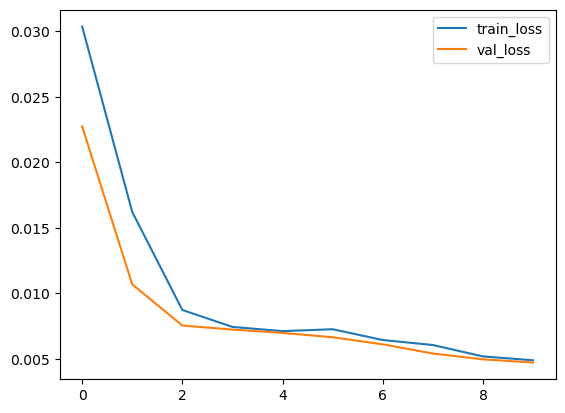

In [33]:
metrics_df.plot()

In [35]:
test_loss = []
model.eval()
for in_stream, out_stream in test_loader:
    in_stream = in_stream.to(device)
    out_stream = out_stream.to(device)
    with torch.no_grad():
        pred = model(in_stream)  
    loss = criterion(pred, out_stream)
    test_loss.append(loss.item())
    print(loss.item())

0.005754441488534212
0.0056703584268689156
0.004259736742824316
0.0036452875938266516
0.005850089713931084
0.004450741223990917
0.003381385700777173
0.0035644061863422394


In [42]:
torch.save(model.state_dict(), 'model_weights.pth')